# A/B Testing - Permutation Test

Similar to bootstrap hypothesis tests permutation tests __don't make any distributional assumptions__ as one might know from a $t$-test. In fact, $t$-test are referred to as ['computationally feasible approximations to permutation tests given the computers of the 1920's young woman'](https://arxiv.org/pdf/1411.5279.pdf). As opposed to boostrap hypothesis tests, where our boostrap distribution is centered at the observed statistic of our test (e.g. difference in means), permutation tests require us to __resample our observations in a way that is consistent with the null hypothesis__. In order to do so we pool the observations of both test and control group, then pick $n_1$ observations withouth replacement and label them as first sample and label the other obersations as the second sample. Here, $n_1$ represents the size of e.g. our test group. This is equivalent to randomly permuting all the labels. Finally, we compute that test statistic of interest (e.g. difference in means) and make inference (please see [below](#Permutation-Test) for full implementation details).

Again, permutation test allow us to __work directly with the statistic of interest__ and generalize to metrics other than means. Permutation tests are __also called 'exact' tests__ where 'exact' refers to a test where all underlying assumptions for deriving a test statistic are met. However, what's important to note is that we __can only test "non-zero" hypotheses__ ($H0: \mu_1 − \mu_2$ = 0) and we __can not use them to obtain confidence intervals__. Last but not least, we cannot test the equality of means when the variances differ. Please note, we don’t need the sample variances to be the same; if the population is positively skewed then the sample with the larger mean naturally has a larger sample variance. What matters is whether the population variances differ when the null hypothesis holds (exchangeability assumption).

## Prepare Data

In [1]:
# Read in sample data
data_control <- read.csv2("data/test_data_control.csv")$x
data_test <- read.csv2("data/test_data_test.csv")$x

In [2]:
# Compare means and standard deviations
print(paste("Control group sample size:", length(data_control),
            "& mean:", round(mean(data_control), 5),
            "& SD:", round(sd(data_control), 5)))
print(paste("Test group sample size:", length(data_test),
            "& mean:", round(mean(data_test), 5),
            "& SD:", round(sd(data_test), 5)))

[1] "Control group sample size: 1322095 & mean: 0.69085 & SD: 2.37184"
[1] "Test group sample size: 1322111 & mean: 0.69797 & SD: 2.41535"


In [3]:
# Check for outliers ...
print(quantile(data_control, probs=c(0.9, 0.99, 0.999, 0.9999)))
print(quantile(data_test, probs=c(0.9, 0.99, 0.999, 0.9999)))

# ... and remove if considered to be necessary
#data_control <- data_control[data_control <= quantile(data_control, probs=0.9999)]
#data_test <- data_test[data_test <= quantile(data_test, probs=0.9999)]

   90%    99%  99.9% 99.99% 
     2     11     24     50 
   90%    99%  99.9% 99.99% 
     2     11     25     50 


## Test Statistic
Even though we use sample means for the comparison of test and control groups most of the time we could also use __any other test statistic of interest__. What's really nice about permutation tests is that we don't need to learn how to conduct another test if we wanted to compare other statistics but means. Instead we can apply the same methodology that we are already familiar with.

In [4]:
# Test statistic for comparison (e.g. mean or variance)
diff.vars  <- function(x,y) var(x) - var(y)
diff.means <- function(x,y) mean(x) - mean(y)

# H0: There is no difference between test & control groups
# H0: mean(a) - mean(a) = 0
h0 <- 0
h0

# Observed difference between groups  (e.g. mean or variance)
obs.diff <- diff.vars(data_test, data_control)
obs.diff <- diff.means(data_test, data_control)
obs.diff

[1] 0

[1] 0.007121903

## Permutation Test
The process for comparing two independent samples of an A/B test via permutation test can be outlined as follows (for implementation details see function below):
1. __Pool__ values of both __samples__ s1 and s2 i.e. test and control group
2. __Repeat__ $r \ge$ 10000 times:
    - __Draw random samples__ of size n1 without replacement from pooled samples representing estimates of the population
    - __Use remaining n2 observations__ for other sample
    - __Compute the test statistic__ of interest e.g. the difference in means
2. __Make inference__ on the resulting distribution i.e. the distribution of the test statistics by calculating a __p-value__ as the fraction of times the random test statistic exceeds or is equal to the observered statistic (e.g. difference in means)

In [9]:
# Permutation test function
permutation.test <- function(x, y, test.statistic, resamples=1000) {
    # Runs two sample permutation test for test statistic of interest
    #
    # Args:
    # - x: Vector with data for either test or control group
    # - y: Vector with data for either test or control group
    # - test.statistic: A function which compares groups
    # - resamples: Number of random permutations (defaults to 1000)
    #
    # Returns:
    # Distribution of test statistic
    
    # Pool data
    data.combined <- c(x, y)
  
    # Get n random permutations of indices with size of experiment group
    permutations <- replicate(resamples, sample(1:length(data.combined), length(x)))
  
    # Apply test statistics for each permutation and return all results
    apply(permutations, 2, function(permutations) {
        # data.combined[permutations] is test sample
        # data.combined[-permutations] is control sample
        test.statistic(data.combined[permutations], data.combined[-permutations])
    })
}

## P-Value
While bootstrap hypothesis tests use confidence intervals to declare the __difference between two samples significant__ or not, __permutation tests use p-values__. Remember, a p-value represents the probability of observing a test statistic greater than or equal to the observed statistic (e.g. difference in means) given the null hypothesis is true. Applied to permutation tests the p-value tells us how likely it is that the random labeling of observations results in e.g. a difference as large the observed one. Given an alpha level of $\alpha = 0.05$ a p-value smaller than $\alpha$ says that a difference this large is very unlikely to happen by chance, hence is significant.

The __one-sided p-value__ is being calculated as the __fraction of times the random statistic is at least as large as the observed one__. We add 1 to numerator and denominator to avoid the equation to break:
\begin{equation*}
\ \frac{x+1}{r+1}
\end{equation*}


where $x$ represents the number of times that $\hat{\theta}^* ≥ \hat{\theta}$ for upper p-values and $\hat{\theta}^* ≤ \hat{\theta}$ for lower p-values. $\hat{\theta}$ is our random test statistic and $*$ denotes the observed statistic. $r$ represents the number of resamples. A __two-sided p-value__ is computed by using both upper and lower p-values and __multiplying the smaller one by 2__.

In [10]:
# P-value function
permutation.pval <- function(test.results, obs.diff, type='two.sided') {
    # Calculates p-value of permutation test of interest as probability
    # of observing an effect at least as extreme as the observed difference
    # between two samples
    #
    # Args:
    # - test.results: Results of permutation test
    # - obs.diff: Vector with data for either test or control group
    # - type: A function which compares groups
    #
    # Returns:
    # P-value
    
    # Replications at least as extreme as observed value
    x <-  sum(permutation.results >= obs.diff)
    
    # Number of permutations
    r <- length(permutation.results)
    
    # Upper and lower p-values (+1 as correction factor)
    p.upper <- round((x + 1) / (r + 1), 4)
    p.lower <- round((r - x  + 1) / (r + 1), 4)
    
    if (type == 'two.sided') {
        return(min(p.upper, p.lower) * 2)
    } else if (type == 'upper') {
        return(p.upper)
    } else if (type == 'lower') {
        return(p.lower)
    }
}

## Results
Finally, we can do both run the permutation test and calculate its corresponding p-value before making final decision on rejecting/accepting $H0$. Then, we can plot a histrogram of our permutation distribution (e.g. distribution of difference in means), add in the value of our null hypothesis and the observed difference between samples and make inference. If the __p-value is less than our accepted threshold we will reject $H0$__. Nonetheless, we can never be completely sure that the null hypothesis is false as we only make inference based on the data.

In [11]:
# Run permutation test and compute p-value as probability
# of observing an effect at least as extreme as observed difference
# Reject H0 is p-value does not satisfy threshold of Type I error rate (alpha)
# This may take a while to run dependent on the number of resamples
alpha <- 0.05
resamples <- 1000
permutation.results <- permutation.test(data_test, data_control, diff.means, resamples)
p.val <- permutation.pval(permutation.results, obs.diff, type='two.sided')

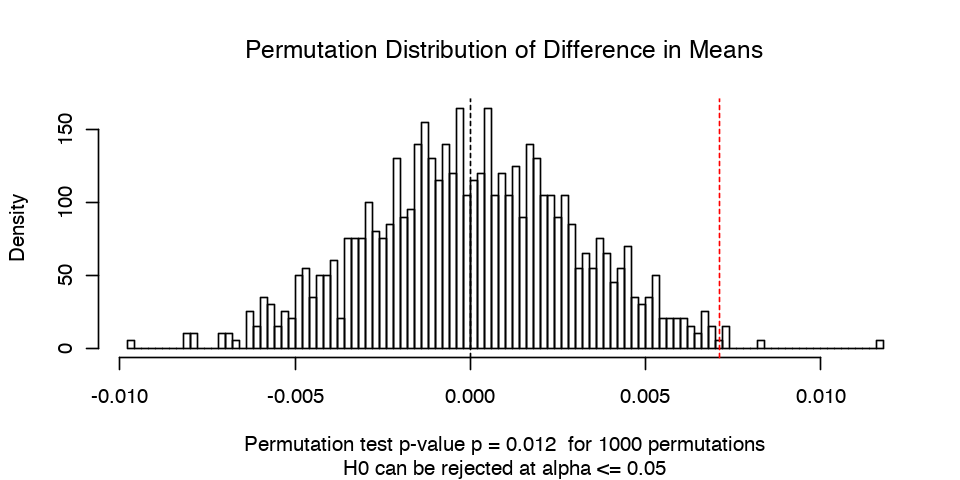

In [18]:
# Set plot size (specific to jupyter notebook)
require(repr)
options(repr.plot.width=8, repr.plot.height=4)

# Plot results
hist(permutation.results,
     breaks = 100,
     prob = T,
     main = "Permutation Distribution of Difference in Means",
     xlim = c(min(permutation.results, obs.diff), max(permutation.results, obs.diff)), 
     sub = ifelse(
         p.val > alpha, 
         paste0("H0 can not be rejected at alpha <= ", alpha),
         paste0("H0 can be rejected at alpha <= ", alpha)),
     xlab = paste(
         "Permutation test p-value p =", p.val, " for", resamples, "permutations"))


# Add H0 and observed difference between groups
abline(v = h0, lty = 2, col = "black")
abline(v = obs.diff, lty = 2, col = "red")

## Comparison
The following cell is meant to give you an idea on how hypothesis testing based on permutation tests compares to a standard $t$-test. Especially with sample sizes as large as the sample data used in this notebook each of the tests comes to the same result of rejecting $H0$.

In [17]:
# Compare permutation test and t-test p-values
paste("Permutation test p-value: ", p.val)
paste("T-test p-value: ", round(t.test(data_test, data_control)$p.val, 4))

[1] "Permutation test p-value:  0.012"

[1] "T-test p-value:  0.0156"

## References
- [What Teachers Should Know about the Bootstrap](https://arxiv.org/pdf/1411.5279.pdf)
- [Exact Test](https://en.wikipedia.org/wiki/Exact_test)